Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


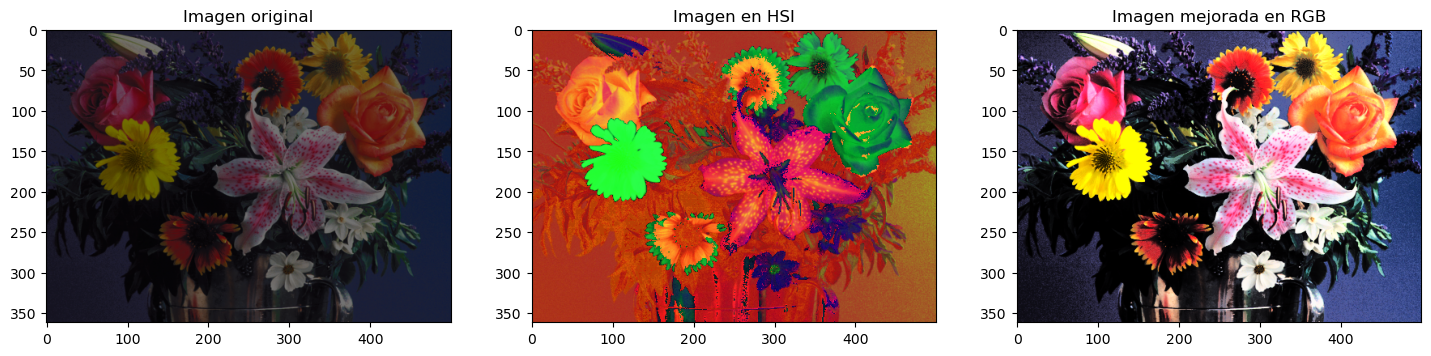

In [1]:
#Ejrcicio 1
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Paso 1: Convertir la imagen de RGB a modelo HSI
def rgb_a_hsi(imagen_rgb):
    # Extraer canales de color RGB
    r, g, b = imagen_rgb[:, :, 0], imagen_rgb[:, :, 1], imagen_rgb[:, :, 2]
    
    # Calcular componentes HSI
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g)**2 + (r - b) * (g - b))
    theta = np.arccos(num / (den + 1e-10))
    h = theta.copy()
    h[b > g] = 2 * np.pi - h[b > g]
    h /= 2 * np.pi

    s = 1 - 3 / (r + g + b + 1e-10) * np.minimum(np.minimum(r, g), b)
    i = (r + g + b) / 3

    # Crear imagen en espacio HSI
    imagen_hsi = np.stack([h, s, i], axis=-1)
    return imagen_hsi

# Paso 2: Tomar la banda de intensidad (I) y ecualizarla
'''def mejorar_banda_intensidad(banda_i):
    # Ecualizar la banda de intensidad
    cdf_i = np.cumsum(np.histogram(banda_i.flatten(), bins=256, range=[0, 1])[0]) / banda_i.size
    i_ecualizada = np.interp(banda_i, np.linspace(0, 1, 256), cdf_i)

    return i_ecualizada'''


#Paso 2.1
#Hice otra para controlar el brillo tomando la formula de transformacion logaritmica de la practica anterior
def mejorar_banda_intensidad(banda_i, gamma=0.5):
    # Aplicar transformación logarítmica con ajuste de gamma
    banda_i_log = np.power(banda_i, gamma)

    # Ecualizar la banda de intensidad transformada
    max_value = np.percentile(banda_i_log, 99)  # Limitar a los valores del 99% para reducir efectos de brillo extremo
    cdf_i = np.cumsum(np.histogram(banda_i_log.flatten(), bins=256, range=[0, max_value])[0]) / banda_i_log.size
    banda_i_ecualizada = np.interp(banda_i_log, np.linspace(0, max_value, 256), cdf_i)

    # Aplicar la transformación inversa logarítmica
    banda_i_ecualizada = np.power(banda_i_ecualizada, 1/gamma)

    return banda_i_ecualizada

# Paso 3: Regresar al modelo RGB
def hsi_a_rgb(imagen_hsi):
    h, s, i = imagen_hsi[:, :, 0], imagen_hsi[:, :, 1], imagen_hsi[:, :, 2]
    h *= 2 * np.pi

    r = np.zeros_like(h)
    g = np.zeros_like(h)
    b = np.zeros_like(h)

    # Sector RG
    condicion_rg = (0 <= h) & (h < 2 * np.pi / 3)
    b[condicion_rg] = i[condicion_rg] * (1 - s[condicion_rg])
    r[condicion_rg] = i[condicion_rg] * (1 + (s[condicion_rg] * np.cos(h[condicion_rg])) / (np.cos(np.pi / 3 - h[condicion_rg])))
    g[condicion_rg] = 3 * i[condicion_rg] - (r[condicion_rg] + b[condicion_rg])

    # Sector GB
    condicion_gb = (2 * np.pi / 3 <= h) & (h < 4 * np.pi / 3)
    r[condicion_gb] = i[condicion_gb] * (1 - s[condicion_gb])
    g[condicion_gb] = i[condicion_gb] * (1 + (s[condicion_gb] * np.cos(h[condicion_gb] - 2 * np.pi / 3)) / (np.cos(np.pi / 3 - (h[condicion_gb] - 2 * np.pi / 3))))
    b[condicion_gb] = 3 * i[condicion_gb] - (r[condicion_gb] + g[condicion_gb])

    # Sector BR
    condicion_br = (4 * np.pi / 3 <= h) & (h <= 2 * np.pi)
    g[condicion_br] = i[condicion_br] * (1 - s[condicion_br])
    b[condicion_br] = i[condicion_br] * (1 + (s[condicion_br] * np.cos(h[condicion_br] - 4 * np.pi / 3)) / (np.cos(np.pi / 3 - (h[condicion_br] - 4 * np.pi / 3))))
    r[condicion_br] = 3 * i[condicion_br] - (g[condicion_br] + b[condicion_br])

    # Crear imagen en espacio RGB
    imagen_rgb = np.stack([r, g, b], axis=-1)
    return imagen_rgb

# Cargar la imagen
ruta_imagen = './img/flowers2.bmp'
imagen_rgb = np.clip(io.imread(ruta_imagen) / 255.0, 0, 1)  # Normalizar y asegurar que esté en el rango correcto

# Visualizar imagen original en RGB
plt.figure(figsize=(24, 12))
plt.subplot(1, 4, 1)
plt.imshow(imagen_rgb)
plt.title('Imagen original')

# Paso 1: Convertir de RGB a HSI
imagen_hsi = rgb_a_hsi(imagen_rgb)

# Visualizar imagen en espacio HSI
plt.subplot(1, 4, 2)
plt.imshow(imagen_hsi)
plt.title('Imagen en HSI')

# Paso 2: Realizar la ecualización de la banda de intensidad (I)
imagen_hsi[:, :, 2] = mejorar_banda_intensidad(imagen_hsi[:, :, 2])

# Paso 3: Regresar de HSI a RGB
imagen_mejorada_rgb = hsi_a_rgb(imagen_hsi)

# Mostrar todas las imágenes
plt.subplot(1, 4, 3)
plt.imshow(imagen_mejorada_rgb)
plt.title('Imagen mejorada en RGB')

plt.show()


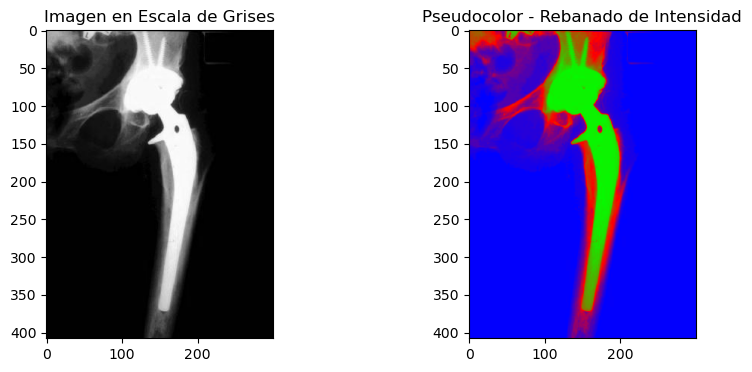

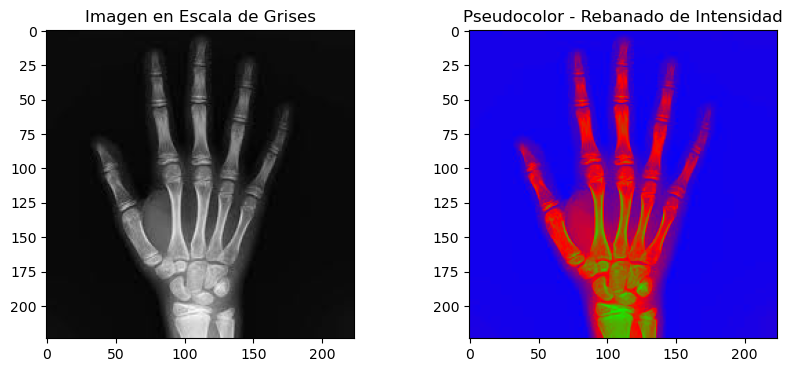

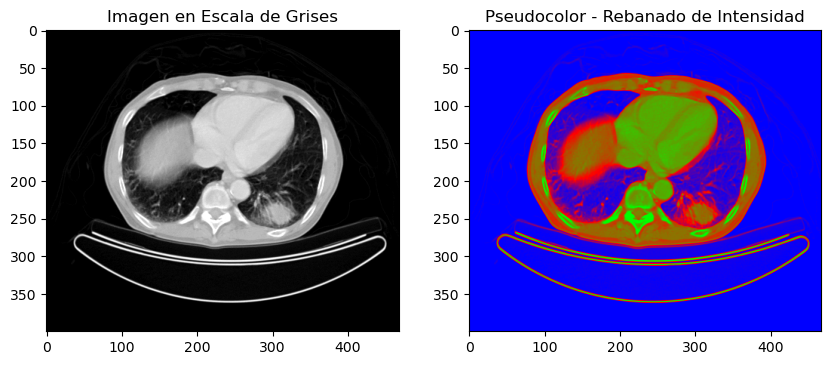

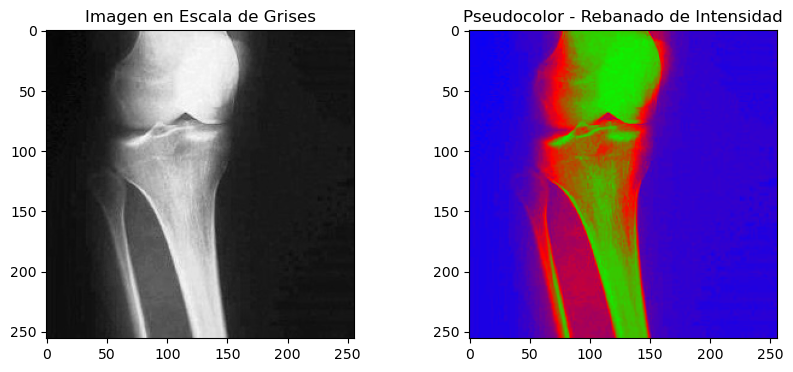

In [31]:
#Ejercicio 2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def pseudocolor_rebanado_intensidad(imagen_gris, num_niveles):
    # Normalizar la imagen en escala de grises al rango [0, 1]
    imagen_gris_norm = (imagen_gris - imagen_gris.min()) / (imagen_gris.max() - imagen_gris.min())

    # Realizar rebanado de intensidad
    intervalos = np.linspace(0, 1, num_niveles + 1)
    niveles_color = np.linspace(0, 1, num_niveles)

    imagen_pseudocolor = np.zeros_like(imagen_gris_norm, dtype=float)

    for i in range(num_niveles):
        condicion = np.logical_and(imagen_gris_norm >= intervalos[i], imagen_gris_norm <= intervalos[i + 1])
        imagen_pseudocolor[condicion] = niveles_color[i]

    return imagen_pseudocolor

# Rutas de las imágenes en escala de grises
rutas_imagenes = ['./img/cadera_1.jpg', './img/mano.jpeg', './img/medtest.png', './img/rodilla_1.jpg']

# Número de niveles de color
num_niveles_color = 256

# Procesar cada imagen y mostrar resultados
for ruta_imagen in rutas_imagenes:
    # Cargar imagen en escala de grises
    imagen_gris = io.imread(ruta_imagen, as_gray=True)

    # Aplicar pseudocolor mediante rebanado de intensidad
    imagen_pseudocolor = pseudocolor_rebanado_intensidad(imagen_gris, num_niveles=num_niveles_color)

    # Mostrar imágenes
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(imagen_gris, cmap='gray')
    plt.title('Imagen en Escala de Grises')
    
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_pseudocolor,vmin=0, cmap='brg', vmax=1)  # Ajustar límites de visualización #'viridis'
    plt.title('Pseudocolor - Rebanado de Intensidad')
    
    plt.show()
